# Model NEATM + REFLECT MODEL @python3.8
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$

$F_\lambda=\frac{\epsilon D^2}{4\Delta ^2}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\pi B(T,\lambda)\cos^2 \phi\cos(\alpha-\theta)d\theta$


# MCMC_NEATM

## define const & import

In [22]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9             #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
Hv = 20
G = 0.15
Ndd = 15
lamdai = [12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model hhq

In [24]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit-273}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))
    F = F*(lamda)**2/cl*1e29
    return F
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
    return flux

### Model reflect

##### cal $H(\alpha)$

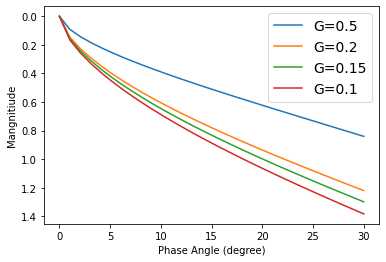

In [25]:
A1,A2 = 3.332,1.862
B1,B2 = 0.631,1.218
C1,C2 = 0.986,0.238
def calW(alpha):
    return np.exp(-90.56*np.tan(alpha/2)**2)
def calphiiS(i,alpha):
    Ci = C1
    if i == 2 :
        Ci = C2
    aa = 0.119+1.341*np.sin(alpha)-0.754*np.sin(alpha)**2
    return 1-Ci*np.sin(alpha)/aa
def calphiiL(i,alpha):
    Ai = A1
    Bi = B1
    if i == 2 :
        Ai = A2
        Bi = B2
    return np.exp(-Ai*np.tan(alpha/2)**Bi)
def calphii(i,alpha):
    W = calW(alpha)
    return W*calphiiS(i,alpha)+(1-W)*calphiiL(i,alpha)
def calHalpha(alpha,G,H):
    aa = (1-G)*calphii(1,alpha)+G*calphii(2,alpha)
    return H - 2.5*np.log10(aa)
def calpromixHalpha(alpha,G,H):
    aa = (1-G)*calphiiL(1,alpha)+G*calphiiL(2,alpha)
    return H - 2.5*np.log10(aa)
#plot 
alpha_degree = np.linspace(0,30,30)
alpha = alpha_degree/180*np.pi
ax = plt.gca()
ax.invert_yaxis()
plt.plot(alpha_degree,calpromixHalpha(alpha,0.5,0),label = 'G=0.5')
plt.plot(alpha_degree,calpromixHalpha(alpha,0.2,0),label = 'G=0.2')
plt.plot(alpha_degree,calpromixHalpha(alpha,0.15,0),label = 'G=0.15')
plt.plot(alpha_degree,calpromixHalpha(alpha,0.1,0),label = 'G=0.1')
plt.legend(fontsize=14)
plt.xlabel("Phase Angle (degree)")
plt.ylabel("Mangnitiude");

##### cal  $F_v^{ref}(\lambda)$

$F_v^{ref}(\lambda) = (\frac{D}{2\Delta})^2 \frac{\Psi(\alpha,G)}{q(G)}[1-\epsilon(\lambda)]F_v^{\odot}$

$F_v^{\odot}=(\frac{R_{\odot}}{r})^2\pi B_v(T_{\odot},\lambda), T_{\odot} = 5,778K, R_{\odot} = 0.00465AU$

$B_v(T_{\odot},\lambda) = \frac{2hc^2}{\lambda ^5} \cdot \frac{1}{\exp(\frac{hc}{\lambda k_B T})-1}$

In [26]:
qG = 0.29+0.684*G
def calcPlanckLambda(lambd, T):
    return np.where(
        (lambd <= 0.0) | (T <= 0.0),
        0.0,
        (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)
        )
def calFsun(lamda,d):
    return (Rsun/(d*au))**2*pi*calcPlanckLambda(lamda,Tsun)
def calFref(D,delta,d,alpha,lamda,epsiLamda):
    cons = (0.5*D/(delta*au))**2*(1-epsiLamda)/qG
    Fref = cons*calpromixHalpha(alpha,G,Hv)*calFsun(lamda,d)
    return Fref*(lamda)**2/cl*1e29
print(f'G = {G}, Hv = {Hv}')

G = 0.15, Hv = 20


##### test plank

/tmp/ipykernel_366405/4169850137.py:6: RuntimeWarning: divide by zero encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)
/tmp/ipykernel_366405/4169850137.py:6: RuntimeWarning: invalid value encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)
/tmp/ipykernel_366405/4169850137.py:6: RuntimeWarning: divide by zero encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)


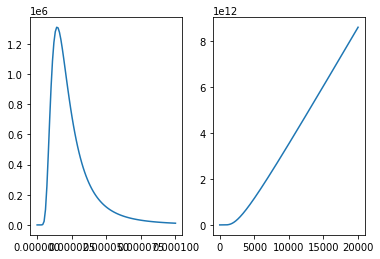

In [27]:
lamdaa = np.linspace(0,100e-6,100)
pl1 = calcPlanckLambda(lamdaa,200)
plt.subplot(1,2,1)
plt.plot(lamdaa,pl1)
Ttt = np.linspace(0,20000,1000)
pl2 = calcPlanckLambda(2e-6,Ttt)
plt.subplot(1,2,2)
plt.plot(Ttt,pl2)

### Model with reflected

In [ ]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit-273}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))
    F = F*(lamda)**2/cl*1e29
    return F
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
    return flux

## read data file

#### 处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [29]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']


#### read data & cal  
$x\equiv \Delta,d,\alpha$

In [30]:
name = '2ev5'
obsdat12 = np.append(w1,w2)
obsdat34 = np.append(w3,w4)
name = '2ev5'
obsec = np.loadtxt(f'ObsECs_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
#print("alpha",alpha_N/pi*180,'\n')
x = (delta_N,d_N,alpha_N)
obsdat12

array([0.04176, 0.06747, 0.03763, 0.05754, 0.03654, 0.03773, 0.03988,
       0.03801, 0.04226, 0.04929, 0.04681, 0.04333, 0.0534 , 0.03407,
       0.0413 , 0.04852, 0.04942, 0.06326, 0.07508, 0.04906, 0.04028,
       0.05296, 0.0483 , 0.04309, 0.0359 , 0.03973, 0.0686 , 0.04454,
       0.03715, 0.0483 , 0.03808, 0.04389, 0.06898, 0.0483 , 0.07797,
       0.05882, 0.04608, 0.08105, 0.03812, 0.04207, 0.0389 , 0.05576,
       0.04184, 0.03948, 0.05016, 0.05587, 0.04122, 0.04733, 0.03933,
       0.03933, 0.04516, 0.26858, 0.2615 , 0.26054, 0.17309, 0.25508,
       0.20677, 0.35701, 0.29887, 0.26809, 0.31295, 0.36499, 0.28806,
       0.3253 , 0.33134, 0.21771, 0.28621, 0.287  , 0.28098, 0.32861,
       0.26612, 0.22196, 0.20058, 0.24767, 0.2815 , 0.325  , 0.23371,
       0.38325, 0.33043, 0.26858, 0.35932, 0.25911, 0.37869, 0.39001,
       0.20926, 0.2828 , 0.29997, 0.29969, 0.31266, 0.29477, 0.28939,
       0.2756 , 0.35308, 0.28306, 0.27687, 0.1991 , 0.37938, 0.31906,
       0.34728, 0.37

##### plot $F_v^{ref}-\lambda$

/tmp/ipykernel_366405/4169850137.py:6: RuntimeWarning: divide by zero encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)
/tmp/ipykernel_366405/4169850137.py:6: RuntimeWarning: invalid value encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)


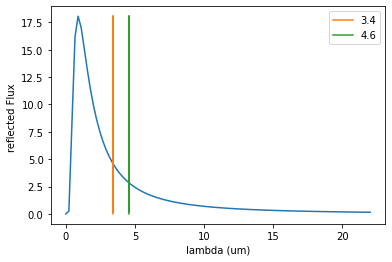

In [31]:
delta0,d0,alpha0 = x[0][10],x[1][10],x[2][10]
arraylam = np.linspace(0,22,100)
refledF = calFref(346,delta0,d0,alpha0,arraylam*1e-6,0.9)
plt.plot(arraylam,refledF)
plt.plot([3.4]*100,refledF,label = '3.4')
plt.plot([4.6]*100,refledF,label = '4.6')
plt.legend() 
plt.xlabel("lambda (um)")
plt.ylabel("reflected Flux ");


#### cal Flex
$F_v^{ast}(\lambda) = F_v^{th}(\lambda) + F_v^{ref}$


##### cal   $F_v^{ref}$ in W1/W2


Text(0.5, 0, 'n')

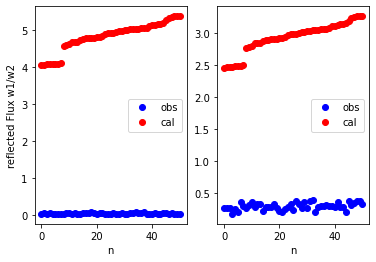

In [33]:
y0 = obsdat12
nn = len(delta_N)
half = int(nn/2)
fluxRef1 = calFref(346,delta_N[0:half],d_N[0:half],alpha_N[0:half],3.4e-6,epsi)
fluxRef2 = calFref(346,delta_N[half:nn],d_N[half:nn],alpha_N[half:nn],4.6e-6,epsi)
plt.subplot(1,2,1)
plt.plot(y0[0:half],'bo',label = 'obs')
plt.plot(fluxRef1,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")
plt.ylabel("reflected Flux w1/w2");
plt.subplot(1,2,2)
plt.plot(y0[half:nn],'bo',label = 'obs')
plt.plot(fluxRef2,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")

##### cal $F_v^{th}$ in W1/W2 

/tmp/ipykernel_366405/3361495899.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


Text(0.5, 0, 'n')

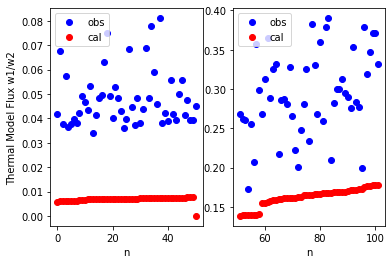

In [36]:
y = obsdat12
nt = np.arange(len(d_N))
theta = [3.4,346]
flux12 = Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=[3.4,4.6])
plt.subplot(1,2,1)
plt.plot(nt[0:half],obsdat12[0:half],'bo',label = 'obs')
plt.plot(nt[0:half],flux12[0:half],'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")
plt.ylabel("Thermal Model Flux w1/w2");
plt.subplot(1,2,2)
plt.plot(nt[half:nn],obsdat12[half:nn],'bo',label = 'obs')
plt.plot(nt[half:nn],flux12[half:nn],'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")

##### cal $F_v^{th}+F_v^{ref}$ in W1\W2

Text(0.5, 0, 'n')

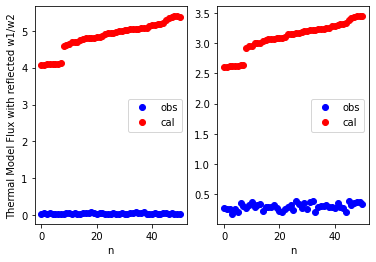

In [37]:
flux01 = flux12[0:half]+fluxRef1
flux02 = flux12[half:nn]+fluxRef2
plt.subplot(1,2,1)
plt.plot(y0[0:half],'bo',label = 'obs')
plt.plot(flux01,'ro',label = 'cal')
plt.legend()
plt.xlabel("n")
plt.ylabel("Thermal Model Flux with reflected w1/w2");
plt.subplot(1,2,2)
plt.plot(y0[half:nn],'bo',label = 'obs')
plt.plot(flux02,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")

##### cal $F_v^{th}$ in W3\W4

/tmp/ipykernel_366405/3361495899.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


Text(0.5, 0, 'n')

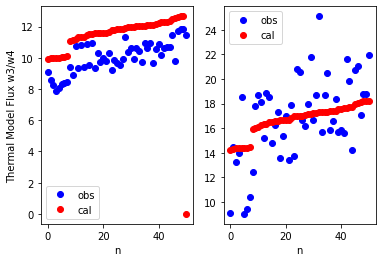

In [44]:
y = obsdat34
nt = np.arange(len(d_N))
theta = [3.0,300]
flux34 = Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
plt.subplot(1,2,1)
plt.plot(y[0:half],'bo',label = 'obs')
plt.plot(flux34[0:half],'ro',label = 'cal')
plt.legend()
plt.xlabel("n")
plt.ylabel("Thermal Model Flux w3/w4");
plt.subplot(1,2,2)
plt.plot(y[half:nn],'bo',label = 'obs')
plt.plot(flux34[half:nn],'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")


##### cal $F_v^{ref}$ in W3/W4

[0.22724259 0.66398851 0.66399328 0.66895229 0.67396159 0.6790218
 0.68930211 0.69190615 0.69451846 0.69714911 0.69978804 0.69979313
 0.70244556 0.70511665 0.70779617 0.70780133 0.71049459 0.7132068
 0.7159276  0.71593288 0.71866761 0.72142165 0.72418443 0.72418979
 0.72696674 0.73256881 0.73539414 0.74683582 0.75264251 0.75850906
 0.76444191 0.91164269]


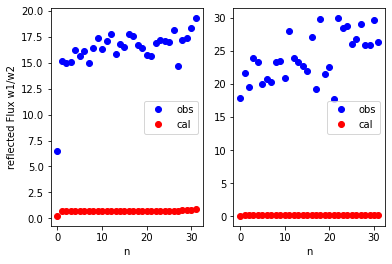

In [339]:
fluxRef341 = calFref(346,delta_N[0:32],d_N[0:32],alpha_N[0:32],12e-6,epsi)
fluxRef342 = calFref(346,delta_N[32:64],d_N[32:64],alpha_N[32:64],22e-6,epsi)
plt.subplot(1,2,1)
plt.plot(y[0:32],'bo',label = 'obs')
plt.plot(fluxRef341,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")
plt.ylabel("reflected Flux w1/w2");
plt.subplot(1,2,2)
plt.plot(y[32:64],'bo',label = 'obs')
plt.plot(fluxRef342,'ro',label = 'cal')
plt.legend() 
plt.xlabel("n")
print(fluxRef341)